In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder

In [7]:
data=pd.read_csv('./train.csv')

In [3]:
X_train=data.drop(['SalePrice'],axis=1)
y_train=data['SalePrice']

In [8]:
def convert_categorical_columns(dataframe):
    for column in dataframe.columns:
        if dataframe[column].dtype == 'object':
            dataframe = dataframe.join(pd.get_dummies(dataframe[column], prefix=column)).drop([column], axis=1)
    return dataframe

In [9]:
def label_encode_boolean_variables(dataframe):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Iterate over each column in the DataFrame
    for column in dataframe.columns:
        # Check if the column contains boolean values
        if dataframe[column].dtype == bool:
            # Apply label encoding to boolean variables
            dataframe[column] = label_encoder.fit_transform(dataframe[column])

    return dataframe

In [10]:
data =convert_categorical_columns(data)
data=label_encode_boolean_variables(data)

In [11]:
data = data.join(pd.get_dummies(data['MSSubClass'], prefix='MSSubClass')).drop(['MSSubClass'], axis=1)

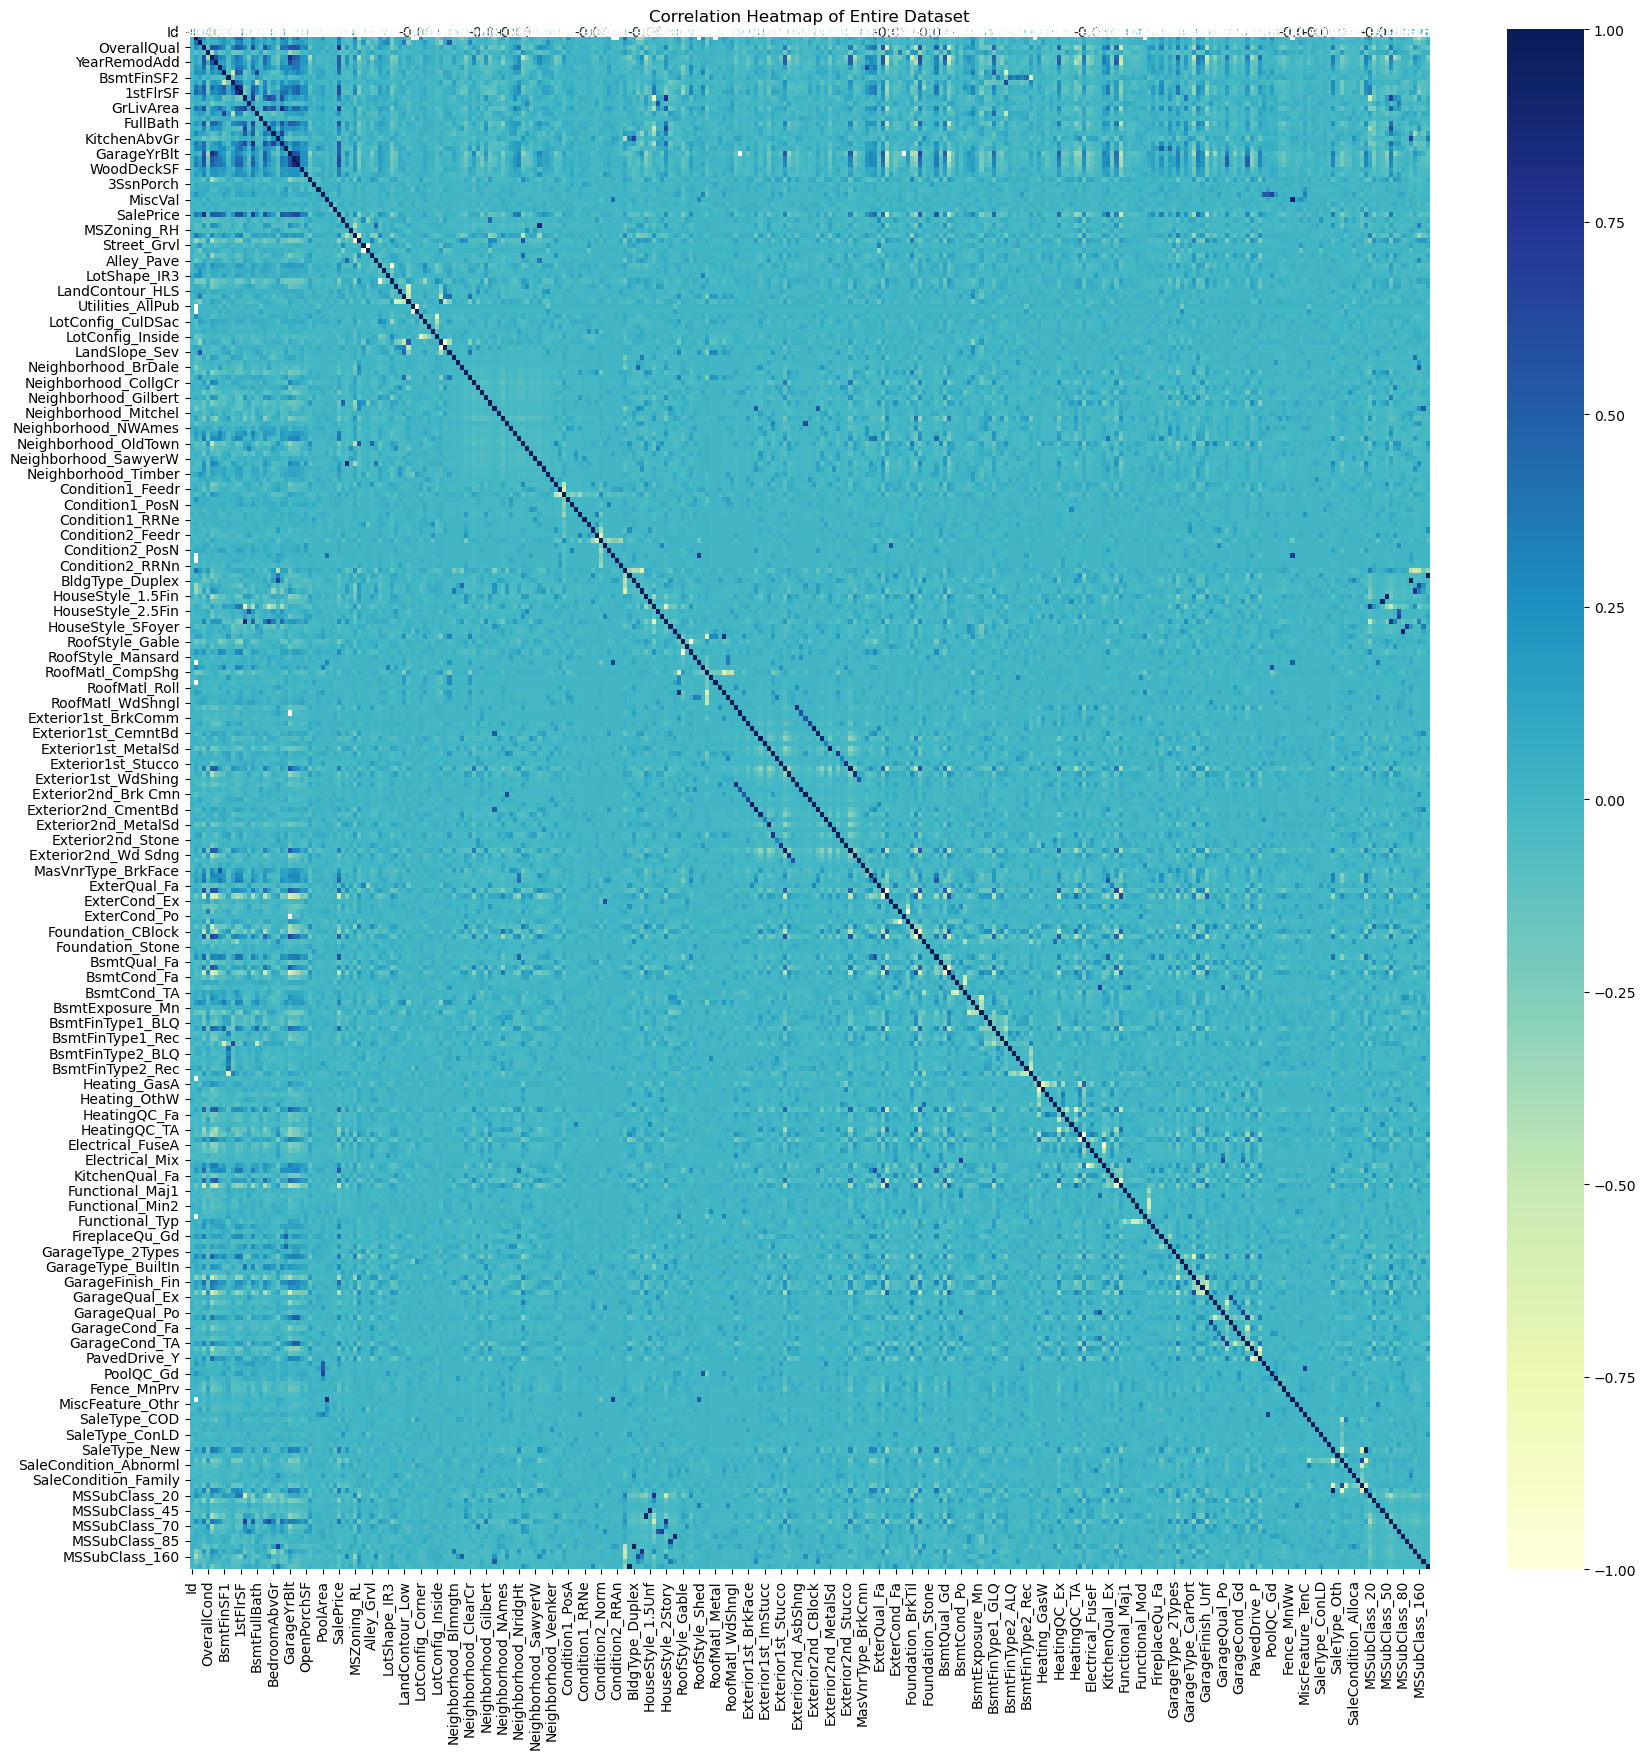

In [12]:
plt.figure(figsize=(20, 20))  # Set the size of the figure
sns.heatmap(data.corr(), annot=True, cmap='YlGnBu')  # Create the heatmap with correlation values annotated

# Set plot title (optional)
plt.title('Correlation Heatmap of Entire Dataset')

# Save the heatmap as an image
plt.savefig('heatmap.png', dpi=300)  # Save as PNG image with higher resolution (dpi)

# Show the plot (optional)
plt.show()

In [1]:
data.corr()

NameError: name 'data' is not defined

In [ ]:
print(data)

In [11]:
print(data.columns)

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80',
       'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160',
       'MSSubClass_180', 'MSSubClass_190'],
      dtype='object', length=303)


In [ ]:
print('hello')